In [1]:
import os, h5py
os.environ['CUDA_VISIBLE_DEVICES']='1'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from tqdm import tqdm
import copy, math

from cremerl import utils, model_zoo, shuffle

import shuffle_test

#import gymnasium as gym

import logging

# Set the logging level to WARNING
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [2]:
expt_name = 'DeepSTARR'

# load data
data_path = '../../data/'
filepath = os.path.join(data_path, expt_name+'_data.h5')
data_module = utils.H5DataModule(filepath, batch_size=100, lower_case=False, transpose=False)


In [3]:
deepstarr2 = model_zoo.deepstarr(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr2, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = model_zoo.DeepSTARR(deepstarr2,
                                  criterion=loss,
                                  optimizer=optimizer_dict)

# load checkpoint for model with best validation performance
standard_cnn = utils.load_model_from_checkpoint(standard_cnn, 'DeepSTARR_standard.ckpt')

# evaluate best model
pred = utils.get_predictions(standard_cnn, data_module.x_test[np.newaxis,100], batch_size=100)

/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
2023-08-09 21:19:06.580016: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 21:19:07.093769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_

Predicting: 0it [00:00, ?it/s]

In [4]:
def get_swap_greedy(x, x_mut, tile_ranges):
    ori = x.copy()
    mut = x_mut.copy()
    for tile_range in tile_ranges:
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]

    return ori, mut

def get_score(pred):
    score1 = pred[0] - pred[2]
    score2 = pred[3] - pred[1]
    return (score1+score2)[0], score1+score2

def generate_tile_ranges(sequence_length, window_size, stride):
    ranges = []
    start = np.arange(0, sequence_length - window_size + stride, stride)

    for s in start:
        e = min(s + window_size, sequence_length)
        ranges.append([s, e])

    if start[-1] + window_size - stride < sequence_length:  # Adjust the last range
        ranges[-1][1] = sequence_length

    return ranges

In [5]:
def get_batch(x, tile_range, tile_ranges_ori, trials):
    test_batch = []
    for i in range(trials):
        test_batch.append(x)
        x_mut = shuffle.dinuc_shuffle(x.copy())
        test_batch.append(x_mut)

        ori = x.copy()
        mut = x_mut.copy()
        
        ori, mut = get_swap_greedy(ori, mut, tile_ranges_ori)
        
        ori[:, tile_range[0]:tile_range[1]] = x_mut[:, tile_range[0]:tile_range[1]]
        mut[:, tile_range[0]:tile_range[1]] = x[:, tile_range[0]:tile_range[1]]
        
        test_batch.append(ori)
        test_batch.append(mut)

    #print(np.array(test_batch).shape)
    return np.array(test_batch)


def get_batch_score(pred, trials):

    score = []
    score_sep = []
    for i in range(0, pred.shape[0], 2):
        # print(f"Viewing number {i}")
        score1 = pred[0] - pred[i]
        score2 = pred[i+1] - pred[1]
        score.append((np.sum((score1, score2)[0])).tolist()) #np.sum(score1+score2, keepdims=True)
        score_sep.append((score1+score2).tolist())
        
    # print(score)
        
    final = np.sum(np.array(score), axis=0)/trials

    #max_ind = np.argmax(final)
    #block_ind = np.argmax(np.array(score)[:, max_ind])
    #print(np.array(total_score)[:, max_ind])
    total_score_sep = np.sum(np.array(score_sep), axis=0)/trials

    #print(np.max(score))
    return final

In [6]:
def extend_sequence(one_hot_sequence):
    A, L = one_hot_sequence.shape

    # Create an all-ones row
    ones_row = np.zeros(L)

    # Add the all-ones row to the original sequence
    new_sequence = np.vstack((one_hot_sequence, ones_row))

    return np.array(new_sequence, dtype='float32')

def taking_action(sequence_with_ones, tile_range):
    start_idx, end_idx = tile_range

    # Ensure the start_idx and end_idx are within valid bounds
    #if start_idx < 0 or start_idx >= sequence_with_ones.shape[1] or end_idx < 0 or end_idx >= sequence_with_ones.shape[1]:
    #    raise ValueError("Invalid tile range indices.")

    # Copy the input sequence to avoid modifying the original sequence
    modified_sequence = sequence_with_ones.copy()

    # Modify the last row within the specified tile range
    modified_sequence[-1, start_idx:end_idx] = 1

    return np.array(modified_sequence, dtype='float32')

In [7]:
def convert_elements(input_list):
    input_list = input_list.tolist()
    num_columns = 5  # Number of elements to process in each group

    # Calculate the number of elements needed to pad the list
    padding_length = num_columns - (len(input_list) % num_columns)
    last_value = input_list[-1]
    padded_list = input_list + [last_value] * padding_length

    # Convert the padded list to a NumPy array for efficient operations
    input_array = np.array(padded_list)
    reshaped_array = input_array.reshape(-1, num_columns)

    # Check if each row has the same value (all 0s or all 1s)
    row_all_zeros = np.all(reshaped_array == 0, axis=1)
    row_all_ones = np.all(reshaped_array == 1, axis=1)

    # Replace all 0s with 0 and all 1s with 1 in the result array
    output_array = np.where(row_all_zeros, 0, np.where(row_all_ones, 1, reshaped_array[:, 0]))

    # Flatten the result array to get the final output list
    output_list = output_array.flatten()

    return output_list

In [22]:
class SeqGame:
    def __init__(self, sequence, model_func):
        self.seq = sequence
        self.ori_seq = sequence.copy()
        self.tile_ranges = generate_tile_ranges(sequence.shape[1], 5, 5)
        self.tile_ranges_done = []
        self.levels = 20
        self.current_level = 0
        self.num_trials = 10
        self.action_size = 50
        
        self.prev_score = -float("inf")
        self.current_score = 0
        
        self.trainer = pl.Trainer(accelerator='gpu', devices='1', logger=None, enable_progress_bar=False)
        self.model = model_func
        
        if self.seq.shape[0]!=5:
            self.seq = extend_sequence(self.seq)
            self.ori_seq = extend_sequence(self.ori_seq)
        
    
    def get_initial_state(self):
        self.seq = self.ori_seq.copy()
        self.tile_ranges = generate_tile_ranges(self.seq.shape[1], 5, 5)
        self.tile_ranges_done = []
        self.current_level = 0
        
        return self.seq
    
    
    def get_next_state(self, action):
        self.prev_score = self.current_score
        self.current_level += 1
        
        self.seq = taking_action(self.seq, self.tile_ranges[action])
        
        batch = get_batch(self.seq[:4, :], self.tile_ranges[action], self.tile_ranges_done, self.num_trials)
        dataloader = torch.utils.data.DataLoader(batch, batch_size=100, shuffle=False)
        pred = np.concatenate(self.trainer.predict(self.model, dataloaders=dataloader))
        
        self.current_score = np.tanh(5 * get_batch_score(pred, self.num_trials)) #ADDED TANH
        
        return self.seq
    
    def get_valid_moves(self):
        return (convert_elements(self.seq[-1, :]) == 0).astype(np.uint8)
    
    def terminate(self): #state
        if self.current_level >= self.levels:
            return True
        if self.current_score < self.prev_score:
            return True
    
        return False
    
    def get_score(self):
        return self.current_score

In [43]:
class Node:
    def __init__(self, env, args, parent=None, action_taken=None, prior=0):
        self.env = env
        self.args = args
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = 0
        self.value_sum = 0
    
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
        
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior #could use np.sqrt or np.log
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_env = copy.deepcopy(self.env)
                child_state = child_env.get_next_state(action)
                
                child = Node(child_env, self.args, self, action, prob)
                self.children.append(child)
        
        return child
    
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.env.current_score
        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, env, args, model):
        self.env = env
        self.args = args
        self.model = model
    
    #@torch.no_grad()
    def search(self):
        root = Node(self.env, self.args)
        
        for search in range(self.args['num_searches']):
            print(f"Conducting search no. {search}")
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
            
            value = self.env.current_score
            is_terminal = self.env.terminate()
            
            if not is_terminal:
                policy, value = self.model(torch.tensor(node.env.seq).unsqueeze(0))
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().detach().numpy()
                valid_moves = node.env.get_valid_moves()
                policy = policy * valid_moves / np.sum(policy)
                
                value = value.item()
                
                node = node.expand(policy)

            node.backpropagate(value)
        
        action_probs = np.zeros(self.env.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

In [ ]:
sequence = data_module.x_test[1].numpy()
seqgame = SeqGame(sequence, standard_cnn)


args = {
    'C': 1.41, 
    'num_searches': 1000
}

mcts = MCTS(seqgame, args)
state = seqgame.get_initial_state()

while True:
    print(state)
    valid_moves = seqgame.get_valid_moves()
    print("Valid moves", [i for i in range(seqgame.action_size) if valid_moves[i]==1])
    #action = int(input("Take action: "))
    #action = np.random.randint(0, 50)
    mcts_probs = mcts.search()
    print(mcts_probs)
    action = np.argmax(mcts_probs)
    print(f"This is the action: {action}")
    
    if valid_moves[action] == 0:
        print("Invalid action")
        continue
    
    state = seqgame.get_next_state(action)
    
    print(seqgame.get_score())
    is_terminal = seqgame.terminate()
    
    if is_terminal:
        print(state)
        print("Game ended")
        break

In [34]:
class CNN_v0(nn.Module):
    def __init__(self, action_dim):
        super(CNN_v0, self).__init__()
        
        self.conv1 = nn.Conv1d(5, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm1d(128)
        
        self.convblock1 = nn.Sequential(
            nn.Conv1d(5, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32), 
            nn.ReLU()
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64), 
            nn.ReLU()
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128), 
            nn.ReLU()
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv1d(128, 80, kernel_size=3, padding=1), 
            nn.BatchNorm1d(80), 
            nn.Linear(4 * action_dim, action_dim)
        )
        
        self.act_conv1 = nn.Conv1d(128, 80, kernel_size=3, padding=1)
        self.act_batchnorm = nn.BatchNorm1d(80)
        self.act_fc1 = nn.Linear(4 * action_dim, action_dim)
        
        self.valueHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Linear(action_dim, 128), 
            nn.Linear(128, 1), 
            nn.Tanh()
        )
        self.val_conv1 = nn.Conv1d(128, 50, kernel_size=3, padding=1)
        self.val_batchnorm = nn.BatchNorm1d(50)
        self.val_fc1 = nn.Linear(action_dim, 128)
        self.val_fc2 = nn.Linear(128, 1)
        
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.activation(x)

In [46]:
class CNN_v0(nn.Module):
    def __init__(self, action_dim):
        super(CNN_v0, self).__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv1d(5, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32), 
            nn.ReLU()
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64), 
            nn.ReLU()
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128), 
            nn.ReLU()
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Flatten(), 
            nn.Linear(50 * 249, action_dim) # 4 * action_dim
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv1d(128, 50, kernel_size=3, padding=1), 
            nn.BatchNorm1d(50), 
            nn.Flatten(), 
            nn.Linear(50 * 249, 128), 
            nn.Linear(128, 1), 
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        
        policy = self.policyHead(x)
        value = self.valueHead(x)
        print("Used")
        return policy, value

[[1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Used
-0.5485266447067261 [0.01043965 0.04153808 0.0138824  0.01522402 0.01623802 0.02686877
 0.01549798 0.01992076 0.01105535 0.01520634 0.00598571 0.01431188
 0.01108298 0.0182792  0.02224099 0.02235403 0.02201602 0.00568408
 0.0280694  0.01539294 0.00574444 0.0085238  0.02777454 0.05954154
 0.0172307  0.0225524  0.01873015 0.01872388 0.02284287 0.0144471
 0.01722462 0.03289738 0.01990077 0.01121524 0.02286295 0.02566862
 0.0077362  0.06444106 0.00934818 0.01120171 0.02055782 0.01618418
 0.01415566 0.02706076 0.01646237 0.01455885 0.05048634 0.01343751
 0.01318062 0.02401913]


/home/yiyu/.conda/envs/tf_2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


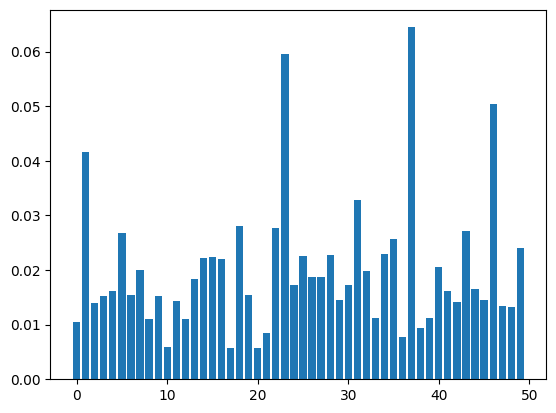

In [47]:
import matplotlib.pyplot as plt

sequence = data_module.x_test[1].numpy()
seqgame = SeqGame(sequence, standard_cnn)


state = seqgame.get_initial_state()
state = seqgame.get_next_state(3)
state = seqgame.get_next_state(5)

print(state)

tensor_state = torch.tensor(state).unsqueeze(0)
model = CNN_v0(seqgame.action_size)

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()



print(value, policy)

plt.bar(range(seqgame.action_size), policy)
plt.show()

In [48]:
sequence = data_module.x_test[1].numpy()
seqgame = SeqGame(sequence, standard_cnn)


args = {
    'C': 2, 
    'num_searches': 1000
}

model = CNN_v0(seqgame.action_size)
model.eval()

mcts = MCTS(seqgame, args, model)
state = seqgame.get_initial_state()

while True:
    print(state)
    valid_moves = seqgame.get_valid_moves()
    print("Valid moves", [i for i in range(seqgame.action_size) if valid_moves[i]==1])
    #action = int(input("Take action: "))
    #action = np.random.randint(0, 50)
    mcts_probs = mcts.search()
    print(mcts_probs)
    action = np.argmax(mcts_probs)
    print(f"This is the action: {action}")
    
    if valid_moves[action] == 0:
        print("Invalid action")
        continue
    
    state = seqgame.get_next_state(action)
    
    print(seqgame.get_score())
    is_terminal = seqgame.terminate()
    
    if is_terminal:
        print(state)
        print("Game ended")
        break

[[1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Valid moves [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Conducting search no. 0
Used
Conducting search no. 1
Used
Conducting search no. 2
Used
Conducting search no. 3
Used
Conducting search no. 4
Used
Conducting search no. 5
Used
Conducting search no. 6
Used
Conducting search no. 7
Used
Conducting search no. 8
Used
Conducting search no. 9
Used
Conducting search no. 10
Used
Conducting search no. 11
Used
Conducting search no. 12
Used
Conducting search no. 13
Used
Conducting search no. 14
Used
Conducting search no. 15
Used
Conducting search no. 16
Used
Conducting search no. 17
Used
Conducting search no. 18
Used
Conducting search no. 19
Used
Conducting search no. 20
Used
Conducting search no. 21
Used
Conducting search no.